In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
from scipy.signal import find_peaks, butter, filtfilt
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import ipywidgets as widgets

In [2]:
# Define filter functions
def butter_bandpass(lowcut, highcut, fs, order=5):
    """Design a bandpass filter."""
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    """Apply bandpass filter to the data."""
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [13]:
# Define core functions
# def detect_r_peaks(ecg_data, fs=125):
#     """Detect R peaks in the ECG data with improved handling for baseline wander."""
#     # Remove baseline wander with high-pass filter
#     b, a = butter(3, 0.5/(fs/2), 'high')
#     ecg_filtered_baseline = filtfilt(b, a, ecg_data)
    
#     # Filter the ECG signal to enhance R-peaks
#     filtered_ecg = butter_bandpass_filter(ecg_filtered_baseline, 5, 15, fs)
    
#     # Normalize signal for more robust peak detection
#     filtered_ecg = filtered_ecg / np.max(np.abs(filtered_ecg))
    
#     # Find R-peaks using a peak detection algorithm
#     r_peaks, _ = find_peaks(filtered_ecg, 
#                           height=0.4,  # Adjusted threshold
#                           distance=0.5*fs,  # Minimum distance between peaks
#                           prominence=0.3)  # Minimum prominence for peaks
    
#     return r_peaks
def detect_r_peaks(ecg_data, fs=125):
    """Improved R-peak detection with adaptive thresholding"""
    # Remove baseline wander
    b, a = butter(3, 0.5/(fs/2), 'high')
    ecg_filtered_baseline = filtfilt(b, a, ecg_data)
    
    # Enhance QRS complex with bandpass filter (wider bandwidth)
    filtered_ecg = butter_bandpass_filter(ecg_filtered_baseline, 5, 25, fs)  # Increased upper cutoff
    
    # Square the signal to enhance peaks
    squared_ecg = filtered_ecg**2
    
    # Apply moving average to smooth
    window_size = int(0.08 * fs)  # 80ms window
    smoothed_ecg = np.convolve(squared_ecg, np.ones(window_size)/window_size, mode='same')
    
    # Use dynamic threshold instead of fixed threshold
    threshold = 0.3 * np.mean(smoothed_ecg) + 0.7 * np.median(smoothed_ecg)
    
    # Find peaks with more appropriate parameters
    r_peaks, _ = find_peaks(smoothed_ecg, 
                          height=threshold,
                          distance=0.2*fs,  # Reduced minimum distance for closer beats
                          prominence=0.3)
    
    # Refine peak locations to maximum in original signal
    refined_peaks = []
    for peak in r_peaks:
        # Look in a small window around detected peak
        window_start = max(0, peak - int(0.02*fs))
        window_end = min(len(ecg_data), peak + int(0.02*fs))
        max_idx = window_start + np.argmax(ecg_data[window_start:window_end])
        refined_peaks.append(max_idx)
    
    return np.array(refined_peaks)
    
# def classify_heartbeat(ecg_data, r_peak_idx, fs=125):
#     """
#     Classify heartbeat as normal, PVC, or other.
#     """
#     # Extract a window around the R-peak
#     window_before = int(0.1 * fs)  # 100ms before
#     window_after = int(0.2 * fs)   # 200ms after
    
#     # Ensure we don't go out of bounds
#     start_idx = max(0, r_peak_idx - window_before)
#     end_idx = min(len(ecg_data), r_peak_idx + window_after)
    
#     beat_segment = ecg_data[start_idx:end_idx]
    
#     # Extract features for classification
#     r_amplitude = ecg_data[r_peak_idx]
    
#     # Calculate RR interval if not the first peak
#     rr_interval = None
#     if r_peak_idx > window_before:
#         # Find the previous R-peak
#         prev_segment = ecg_data[max(0, r_peak_idx - 2*window_before):r_peak_idx - int(0.05*fs)]
#         if len(prev_segment) > 0:
#             prev_peaks, _ = find_peaks(prev_segment, height=0.5*np.max(prev_segment))
#             if len(prev_peaks) > 0:
#                 rr_interval = (r_peak_idx - (max(0, r_peak_idx - 2*window_before) + prev_peaks[-1])) / fs
    
#     # QRS width approximation
#     qrs_start = r_peak_idx
#     for i in range(r_peak_idx, max(0, r_peak_idx - window_before), -1):
#         if abs(ecg_data[i] - ecg_data[i-1]) < 0.1 * abs(r_amplitude):
#             qrs_start = i
#             break
    
#     qrs_end = r_peak_idx
#     for i in range(r_peak_idx, min(len(ecg_data), r_peak_idx + window_before)):
#         if i+1 < len(ecg_data) and abs(ecg_data[i] - ecg_data[i+1]) < 0.1 * abs(r_amplitude):
#             qrs_end = i
#             break
    
#     qrs_width = (qrs_end - qrs_start) / fs
    
#     # Classification rules
#     if qrs_width < 0.12 and (rr_interval is None or (rr_interval > 0.6 and rr_interval < 1.2)):
#         return "normal"
#     elif qrs_width > 0.12:
#         return "PVC"  # Premature ventricular contraction typically has wider QRS
#     else:
#         return "other"

def classify_heartbeat(ecg_data, r_peak_idx, all_peaks=None, fs=125):
    """
    Enhanced heartbeat classification using more features
    """
    # Extract window around the R-peak
    window_before = int(0.2 * fs)  # 200ms before
    window_after = int(0.4 * fs)   # 400ms after
    
    # Ensure we don't go out of bounds
    start_idx = max(0, r_peak_idx - window_before)
    end_idx = min(len(ecg_data), r_peak_idx + window_after)
    
    beat_segment = ecg_data[start_idx:end_idx]
    
    # Calculate RR intervals - previous and next
    prev_rr = next_rr = None
    rr_irregularity = 0
    
    if all_peaks is not None:
        peak_idx = np.where(all_peaks == r_peak_idx)[0]
        if len(peak_idx) > 0:
            peak_idx = peak_idx[0]
            # Previous RR interval
            if peak_idx > 0:
                prev_rr = (r_peak_idx - all_peaks[peak_idx-1]) / fs
            # Next RR interval
            if peak_idx < len(all_peaks)-1:
                next_rr = (all_peaks[peak_idx+1] - r_peak_idx) / fs
                
            # Calculate RR irregularity if both intervals exist
            if prev_rr and next_rr:
                rr_irregularity = abs(prev_rr - next_rr) / max(prev_rr, next_rr)
    
    # QRS width calculation with improved precision
    qrs_start = r_peak_idx
    threshold = 0.2 * abs(ecg_data[r_peak_idx])
    for i in range(r_peak_idx, max(0, r_peak_idx - window_before), -1):
        if abs(ecg_data[i] - ecg_data[i-1]) < threshold:
            qrs_start = i
            break
    
    qrs_end = r_peak_idx
    for i in range(r_peak_idx, min(len(ecg_data), r_peak_idx + window_before)):
        if i+1 < len(ecg_data) and abs(ecg_data[i] - ecg_data[i+1]) < threshold:
            qrs_end = i
            break
    
    qrs_width = (qrs_end - qrs_start) / fs
    
    # QRS morphology - extract shape features
    r_amplitude = ecg_data[r_peak_idx]
    
    # ST segment elevation/depression
    st_point_idx = min(len(ecg_data)-1, r_peak_idx + int(0.12*fs))
    st_elevation = ecg_data[st_point_idx] - np.mean(ecg_data[max(0, r_peak_idx - int(0.05*fs)):r_peak_idx])
    
    # Improved classification rules
    # PVC typically has:
    # - Wider QRS complex
    # - Different QRS morphology
    # - Premature (shorter preceding RR interval)
    # - Compensatory pause (longer following RR interval)
    
    if prev_rr and prev_rr < 0.7 and qrs_width > 0.11:
        return "PVC"  # Premature with wide QRS
    elif qrs_width > 0.12:
        return "PVC"  # Wide QRS complex
    elif rr_irregularity > 0.3:
        return "other"  # Irregular rhythm
    elif abs(st_elevation) > 0.2 * abs(r_amplitude):
        return "other"  # Significant ST changes
    else:
        return "normal"

In [18]:
def read_ecg_file(file_path):
    """Read ECG data from a CSV file, handling comment lines."""
    try:
        # Read data, skipping comment lines
        with open(file_path, 'r') as f:
            lines = [line.strip() for line in f if not line.startswith('#')]
        
        # Convert to numeric values
        ecg_data = np.array([float(line) for line in lines])
        
        return ecg_data
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None

# def process_ecg_file(file_path, fs=125):
#     """Process a single ECG file and return heartbeat info."""
#     try:
#         ecg_data = read_ecg_file(file_path)
        
#         if ecg_data is None:
#             return []
            
#         # Check data length
#         if len(ecg_data) != 2500:
#             print(f"Warning: {file_path} does not contain exactly 2500 data points. Found {len(ecg_data)} points.")
        
#         # Detect R-peaks
#         r_peaks = detect_r_peaks(ecg_data, fs)
        
#         # Process each heartbeat
#         heartbeats = []
#         for peak_idx in r_peaks:
#             # Calculate timestamp in seconds
#             timestamp = peak_idx / fs
            
#             # Classify the heartbeat
#             beat_type = classify_heartbeat(ecg_data, peak_idx, fs)
            
#             heartbeats.append({
#                 "timestamp": timestamp,
#                 "beat_type": beat_type
#             })
        
#         return heartbeats
    
#     except Exception as e:
#         print(f"Error processing {file_path}: {e}")
#         return []

def process_ecg_file(file_path, fs=125):
    """Process a single ECG file with improved detection and classification."""
    try:
        ecg_data = read_ecg_file(file_path)
        
        if ecg_data is None:
            return []
            
        # Detect R-peaks with improved method
        r_peaks = detect_r_peaks(ecg_data, fs)
        
        # Process each heartbeat
        heartbeats = []
        for peak_idx in r_peaks:
            # Calculate timestamp in seconds
            timestamp = peak_idx / fs
            
            # Classify the heartbeat - pass all peaks for RR analysis
            beat_type = classify_heartbeat(ecg_data, peak_idx, r_peaks, fs)
            
            heartbeats.append({
                "timestamp": timestamp,
                "beat_type": beat_type
            })
        
        return heartbeats
    
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return []

In [19]:
def visualize_ecg_analysis(file_path=None, ecg_data=None, heartbeats=None, fs=125, save_fig=False):
    """Visualize ECG data with detected heartbeats marked."""
    try:
        if ecg_data is None and file_path is not None:
            ecg_data = read_ecg_file(file_path)
        
        if ecg_data is None:
            print("No ECG data provided!")
            return
        
        # Create time axis
        time = np.arange(len(ecg_data)) / fs
        
        # Plot ECG signal
        plt.figure(figsize=(15, 6))
        plt.plot(time, ecg_data, 'b-', label='ECG Signal')
        
        # Mark heartbeats if provided
        if heartbeats:
            for beat in heartbeats:
                beat_time = beat['timestamp']
                beat_type = beat['beat_type']
                
                if beat_type == 'normal':
                    marker = 'go'  # Green circle for normal beats
                elif beat_type == 'PVC':
                    marker = 'ro'  # Red circle for PVC beats
                else:
                    marker = 'yo'  # Yellow circle for other beats
                    
                plt.plot(beat_time, ecg_data[int(beat_time * fs)], marker, markersize=8)
            
            # Add legend
            from matplotlib.lines import Line2D
            legend_elements = [
                Line2D([0], [0], color='b', lw=2, label='ECG Signal'),
                Line2D([0], [0], marker='o', color='g', label='Normal Beat', markersize=8, linestyle='None'),
                Line2D([0], [0], marker='o', color='r', label='PVC Beat', markersize=8, linestyle='None'),
                Line2D([0], [0], marker='o', color='y', label='Other Beat', markersize=8, linestyle='None')
            ]
            plt.legend(handles=legend_elements, loc='upper right')
        
        # Add labels and title
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        title = f'ECG Analysis'
        if file_path:
            title += f': {os.path.basename(file_path)}'
        plt.title(title)
        plt.grid(True)
        
        # Save figure if requested
        if save_fig and file_path:
            output_dir = os.path.dirname(file_path)
            output_path = os.path.join(output_dir, f"{os.path.basename(file_path).split('.')[0]}_analysis.png")
            plt.savefig(output_path)
            print(f"Analysis visualization saved to {output_path}")
        
        # Show plot
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error visualizing ECG data: {e}")

In [20]:
def analyze_single_file(file_path, fs=125):
    """Analyze a single ECG file and display results."""
    print(f"Analyzing {os.path.basename(file_path)}...")
    
    # Process the file
    heartbeats = process_ecg_file(file_path, fs)
    
    # Display results
    print(f"Found {len(heartbeats)} heartbeats:")
    beats_df = pd.DataFrame(heartbeats)
    display(beats_df)
    
    # Count beat types
    beat_types = [beat["beat_type"] for beat in heartbeats]
    normal_count = beat_types.count("normal")
    pvc_count = beat_types.count("PVC")
    other_count = beat_types.count("other")
    
    print("\nSummary:")
    print(f"  Normal beats: {normal_count} ({normal_count/len(heartbeats)*100:.1f}%)")
    print(f"  PVC beats: {pvc_count} ({pvc_count/len(heartbeats)*100:.1f}%)")
    print(f"  Other beats: {other_count} ({other_count/len(heartbeats)*100:.1f}%)")
    
    # Visualize results
    visualize_ecg_analysis(file_path=file_path, heartbeats=heartbeats)
    
    return heartbeats

Analyzing ecg_1329.csv...
Found 23 heartbeats:


,timestamp,beat_type
0,0.144,other
1,0.400,other
2,1.120,other
3,2.216,other
4,3.352,other
5,4.568,normal
6,5.808,normal
7,7.064,normal
8,8.304,normal
9,9.608,normal



Summary:
  Normal beats: 9 (39.1%)
  PVC beats: 1 (4.3%)
  Other beats: 13 (56.5%)


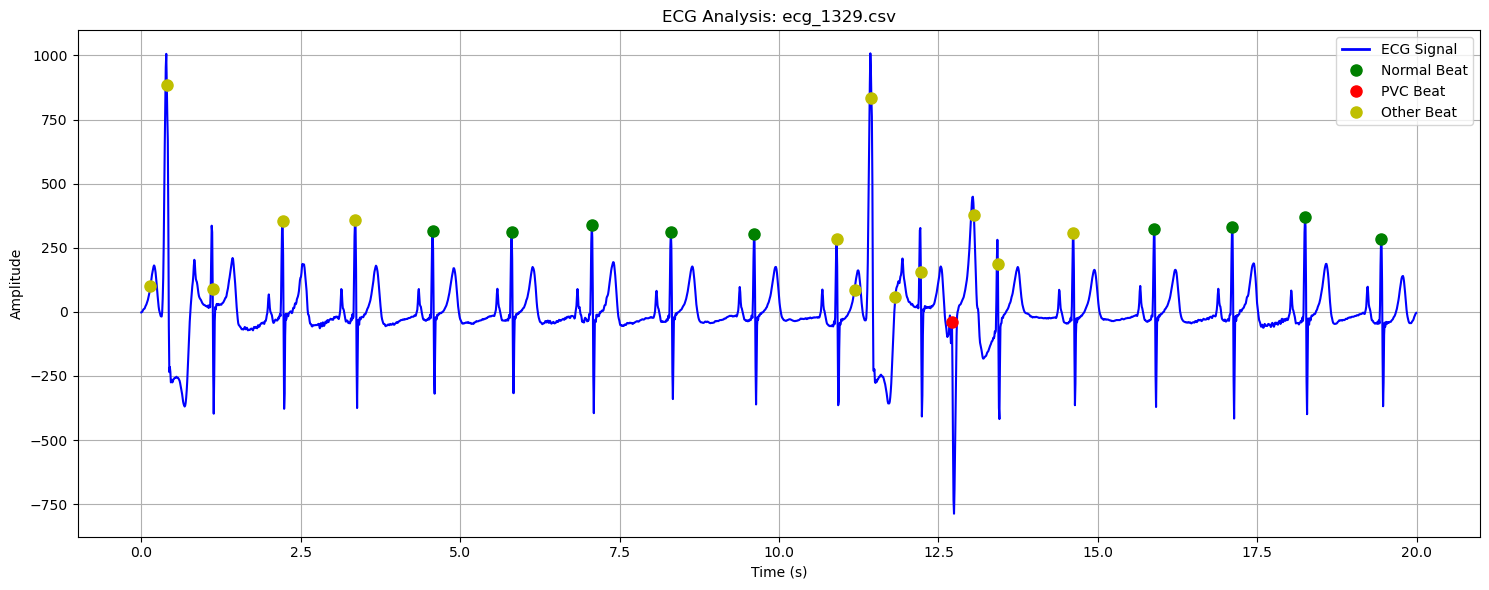

In [21]:
# Provide the path to your ECG file
file_path = "Data/Sleep_on_20240809_230342_by_Etienne_5010176_94DEB87F66D7_RAWECG/ecg_1329.csv"  # Replace with actual path
heartbeats = analyze_single_file(file_path)

In [12]:
def analyze_folder(folder_path, pattern="ecg_*.csv"):
    """Analyze all matching ECG files in a folder."""
    import glob
    
    # Find all matching files
    file_pattern = os.path.join(folder_path, pattern)
    files = sorted(glob.glob(file_pattern))
    
    if not files:
        print(f"No files matching '{pattern}' found in {folder_path}")
        return
    
    print(f"Found {len(files)} files to analyze")
    
    # Create a selector widget
    file_dropdown = widgets.Dropdown(
        options=[(os.path.basename(f), f) for f in files],
        description='Select file:',
        style={'description_width': 'initial'},
        layout={'width': '50%'}
    )
    
    # Analysis button
    analyze_button = widgets.Button(
        description='Analyze Selected File',
        button_style='primary'
    )
    
    # Output area
    output_area = widgets.Output()
    
    # Define button click handler
    def on_analyze_button_clicked(b):
        with output_area:
            clear_output()
            selected_file = file_dropdown.value
            if selected_file:
                analyze_single_file(selected_file)
    
    # Connect button to handler
    analyze_button.on_click(on_analyze_button_clicked)
    
    # Display widgets
    display(widgets.VBox([file_dropdown, analyze_button]))
    display(output_area)

# Example usage
analyze_folder("Data/Sleep_on_20240809_230342_by_Etienne_5010176_94DEB87F66D7_RAWECG/")

Found 1386 files to analyze


Output()